<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/hw_semantic_segmentation_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>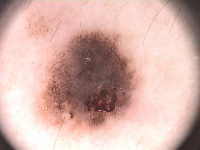</td><td>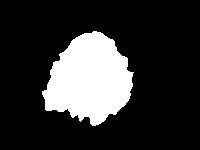</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-06-24 18:06:30--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-06-24 18:06:30--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d120f124b8f2c5ff901369a59.dl.dropboxusercontent.com/cd/0/inline/B-kw7YPtzT4dEpbEVc1AP3y3M63HtZLvJwo929UOmkfFFr09XNrRIQzFEcXs3hVNx3hg9_aZjB3sKhTKMcz5Fs8j6xpRBDn1o6I4vNP1NiNhWwwqxGXgMKNYvOuGONJZnm1PW-Jd1beT6ylTz0TQs27CV-HQdh9toFakGt6N8TeJJw/file# [following]
--2023-06-24 18:06:31--  https://uc6d120f124b8f2c5ff901369a59.dl.dropboxusercontent.com/cd/0/inline/B-kw7YPtzT4dEpbEVc1AP3y3M63HtZLvJwo929UOmkfFFr09XNrRIQzFEcXs3hVNx3hg9_aZjB

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

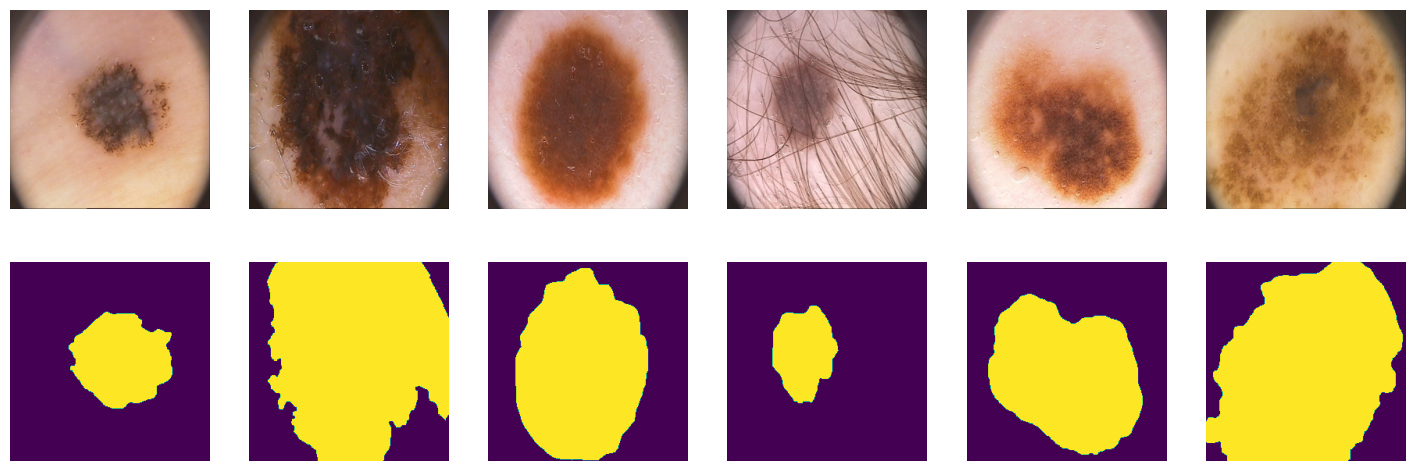

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

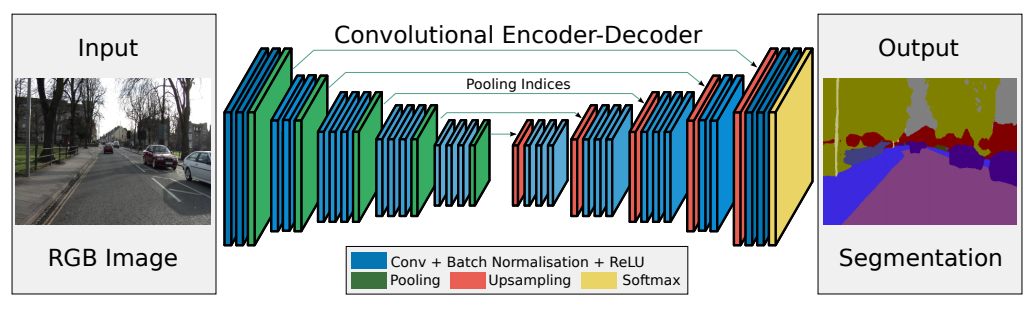

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=in_c,out_channels=64,kernel_size=3,padding=1, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),

                                      nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        #######################################################
        self.enc_conv1 = nn.Sequential(nn.Conv2d(64,64,3,padding=1,bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),

                                       nn.Conv2d(64,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       )

        self.pool1 =  nn.MaxPool2d(kernel_size=2,return_indices=True) # 128 -> 64
        ######################################################
        self.enc_conv2 = nn.Sequential(nn.Conv2d(128,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),

                                       nn.Conv2d(128,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),

                                       nn.Conv2d(128,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU()
                                       )

        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        #######################################################
        self.enc_conv3 = nn.Sequential(nn.Conv2d(256,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256,512,3,padding=1,bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU()
                                       )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        ##############################################################
        self.enc_conv4 = nn.Sequential(nn.Conv2d(512,512,3,padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),

                                       nn.Conv2d(512,512,3,padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),

                                       nn.Conv2d(512,512,3,padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       )

        self.pool4 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        ##################################################3

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2)# 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.Conv2d(512,512,3,padding=1,bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),

                                       nn.Conv2d(512,512,3,padding=1,bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),

                                       nn.Conv2d(512,512,3,padding=1,bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())

        ##########################################################

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(nn.Conv2d(512,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256,256,3,padding=1,bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        ###############################################################
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(nn.Conv2d(256,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),

                                       nn.Conv2d(128,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),

                                       nn.Conv2d(128,128,3,padding=1,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        #########################################################
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(nn.Conv2d(128,64,3,padding=1,bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),

                                       nn.Conv2d(64,64,3,padding=1,bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        ####################################################################
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2)

        self.dec_conv4 = nn.Sequential(nn.Conv2d(64, out_channels=64, kernel_size=3,padding=1,bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels = 1, kernel_size=3,padding=1,bias=False),
                                       nn.BatchNorm2d(1)#,
                                       #nn.ReLU(),
                                       #nn.Softmax()
                                       )
        #self.dec_conv5 = nn.Conv2d(64,1,1, bias=False)

        ####################################################################
    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0=x.size()

        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()

        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()

        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()

        x = self.enc_conv4(x)
        x, ind4 = self.pool4(x)
        size4 = x.size()

        # decoder
        x = self.upsample0(x, ind4, output_size=size3)
        x = self.dec_conv0(x)

        x = self.upsample1(x, ind3, output_size=size2)
        x = self.dec_conv1(x)

        x = self.upsample2(x, ind2, output_size=size1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, ind1, output_size=size0)
        x = self.dec_conv3(x)

        x = self.upsample4(x, ind0)
        x = self.dec_conv4(x)# no activation

        return x

In [ ]:
from torchinfo import summary

model = SegNet(3)
batch_size = 16
summary(model, input_size=(batch_size, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
SegNet                                   [16, 1, 256, 256]         --
├─Sequential: 1-1                        [16, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [16, 64, 256, 256]        1,728
│    └─BatchNorm2d: 2-2                  [16, 64, 256, 256]        128
│    └─ReLU: 2-3                         [16, 64, 256, 256]        --
│    └─Conv2d: 2-4                       [16, 64, 256, 256]        36,864
│    └─BatchNorm2d: 2-5                  [16, 64, 256, 256]        128
│    └─ReLU: 2-6                         [16, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [16, 64, 128, 128]        --
├─Sequential: 1-3                        [16, 128, 128, 128]       --
│    └─Conv2d: 2-7                       [16, 64, 128, 128]        36,864
│    └─BatchNorm2d: 2-8                  [16, 64, 128, 128]        128
│    └─ReLU: 2-9                         [16, 64, 128, 128]        --
│

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean((torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1. + torch.exp(- torch.abs(y_pred)))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            #opt  # update weights
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        # show intermediate results
        model.eval()  # testing mode

        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().to('cpu') > 0  # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
  model.eval()  # testing mode
  Y_pred = [ X_batch for X_batch, _ in data]
  return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
  model.eval()  # testing mode
  scores = 0
  for X_batch, Y_label in data:
      Y_pred = model(X_batch.to(device))
      scores += metric(Y_pred > 0, Y_label.to(device)).mean().item()

  return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet(3).to(device)

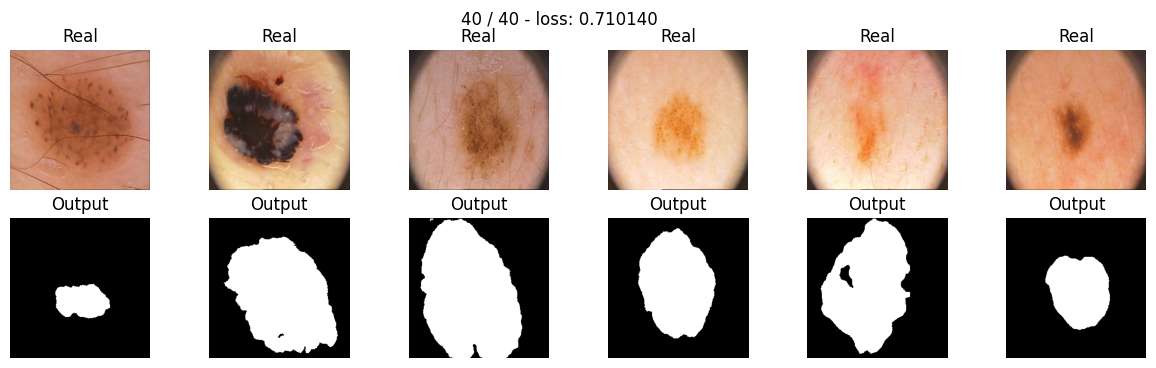

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=1e-03)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6779999732971191

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    intersection = 2. * torch.sum(y_pred * y_real)
    union = torch.sum(y_pred + y_real)
    result = (1. - (intersection + smooth) / (union + smooth)).mean()
    return result

Проводим тестирование:

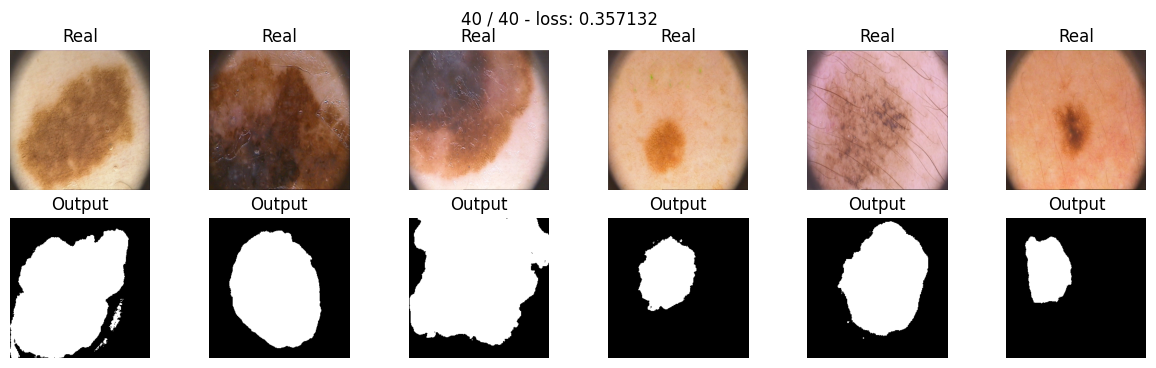

In [ ]:
model_dice = SegNet(3).to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.6439999639987946

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps=1e-8, alpha=-1., gamma=2):
  y_pred = torch.sigmoid(y_pred)
  funct = y_real * y_pred + (1 - y_real) * (1 - y_pred)
  loss = alpha * (1 - funct)**gamma * torch.log(funct + eps)
  return loss.mean()

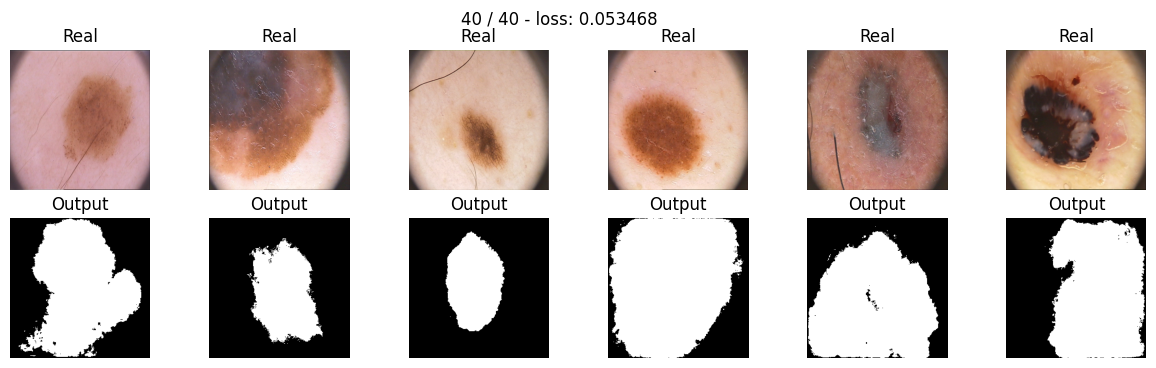

In [ ]:
model_focal = SegNet(3).to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6819999814033508

In [ ]:
class TverskyLoss(nn.Module):
  def __init__(self, alpha=0.3, beta=0.7, ignore_index=None, reduction='mean'):
    super(TverskyLoss, self).__init__()

    self.alpha = alpha
    self.beta = beta
    self.ignore_index = ignore_index
    self.smooth = 10
    self.reduction = reduction
    s = self.beta + self.alpha
    if s != 1:
        self.beta = self.beta / s
        self.alpha = self.alpha / s

  def forward(self, y_real, y_pred, mask=None):
    batch_size = y_pred.size(0)
    bg_target = 1 - y_real

    if self.ignore_index is not None:
        valid_mask = (y_real != self.ignore_index).float()
        y_pred = y_pred.float().mul(valid_mask)  # can not use inplace for bp
        y_real = y_real.float().mul(valid_mask)
        bg_target = bg_target.float().mul(valid_mask)

    y_pred = torch.sigmoid(y_pred).view(batch_size, -1)
    y_real = y_real.view(batch_size, -1)
    bg_target = bg_target.view(batch_size, -1)

    P_G = torch.sum(y_pred * y_real, 1)  # TP
    P_NG = torch.sum(y_pred * bg_target, 1)  # FP
    NP_G = torch.sum((1 - y_pred) * y_real, 1)  # FN

    tversky_index = P_G / (P_G + self.alpha * P_NG + self.beta * NP_G + self.smooth)

    loss = 1. - tversky_index

    if self.reduction == 'none':
        loss = loss
    elif self.reduction == 'sum':
        loss = torch.sum(loss)
    else:
        loss = torch.mean(loss)
    return loss

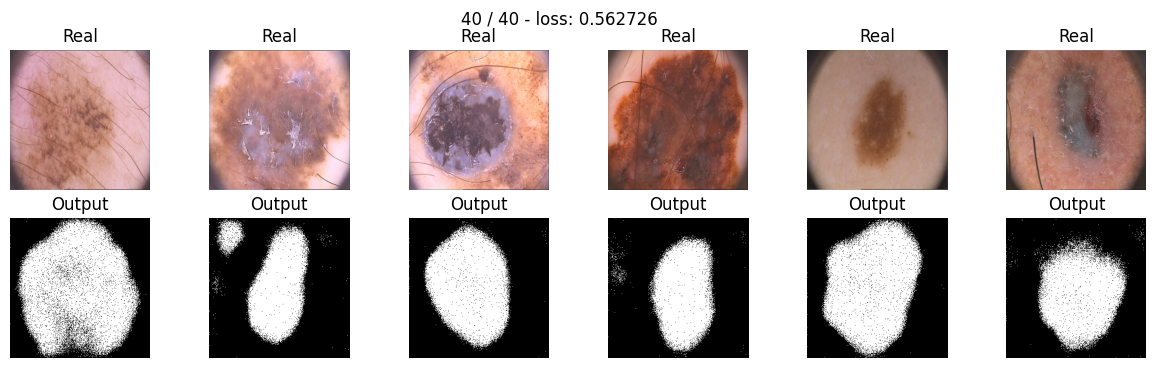

In [ ]:
model_tversky = SegNet(3).to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
tversky_loss = TverskyLoss()
train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

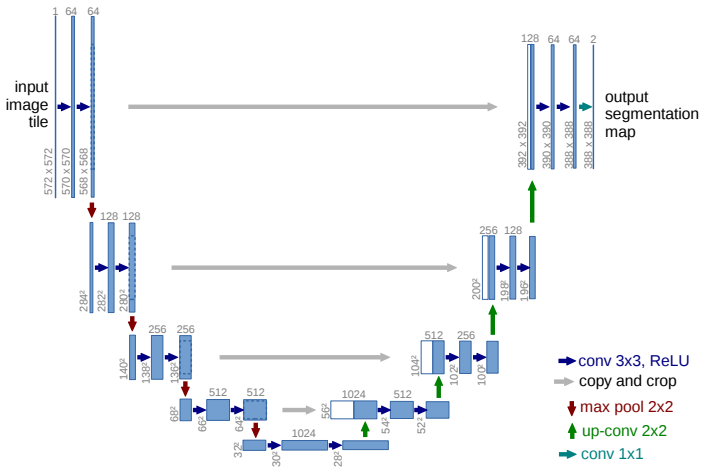

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
      super().__init__()

      self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(out_c)

      self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(out_c)

      self.relu = nn.ReLU()

  def forward(self, inputs):
      x = self.conv1(inputs)
      x = self.bn1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)

      return x

In [ ]:
class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
      super().__init__()

      self.conv = conv_block(in_c, out_c)
      self.pool = nn.MaxPool2d((2, 2))

  def forward(self, inputs):
      x = self.conv(inputs)
      p = self.pool(x)

      return x, p

In [ ]:
class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
      super().__init__()

      self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
      self.conv = conv_block(out_c + out_c, out_c)

  def forward(self, inputs, skip):
      x = self.up(inputs)
      x = torch.cat([x, skip], axis=1)
      x = self.conv(x)

      return x

In [ ]:
class UNet(nn.Module):
  def __init__(self):
      super().__init__()

      self.e1 = encoder_block(3, 64)
      self.e2 = encoder_block(64, 128)
      self.e3 = encoder_block(128, 256)
      self.e4 = encoder_block(256, 512)

      self.b = conv_block(512, 1024)

      self.d1 = decoder_block(1024, 512)
      self.d2 = decoder_block(512, 256)
      self.d3 = decoder_block(256, 128)
      self.d4 = decoder_block(128, 64)

      self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

  def forward(self, inputs):

      s1, p1 = self.e1(inputs)
      s2, p2 = self.e2(p1)
      s3, p3 = self.e3(p2)
      s4, p4 = self.e4(p3)

      b = self.b(p4)

      d1 = self.d1(b, s4)
      d2 = self.d2(d1, s3)
      d3 = self.d3(d2, s2)
      d4 = self.d4(d3, s1)

      outputs = self.outputs(d4)

      return outputs

In [ ]:
unet_model = UNet().to(device)

In [ ]:
model_unet = UNet()
batch_size = 16
summary(model_unet, input_size=(16, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 256, 256]         --
├─encoder_block: 1-1                     [16, 64, 256, 256]        --
│    └─conv_block: 2-1                   [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-1                  [16, 64, 256, 256]        1,792
│    │    └─BatchNorm2d: 3-2             [16, 64, 256, 256]        128
│    │    └─ReLU: 3-3                    [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-4                  [16, 64, 256, 256]        36,928
│    │    └─BatchNorm2d: 3-5             [16, 64, 256, 256]        128
│    │    └─ReLU: 3-6                    [16, 64, 256, 256]        --
│    └─MaxPool2d: 2-2                    [16, 64, 128, 128]        --
├─encoder_block: 1-2                     [16, 128, 128, 128]       --
│    └─conv_block: 2-3                   [16, 128, 128, 128]       --
│    │    └─Conv2d: 3-7                  [16, 128, 128, 128]       73,856
│ 

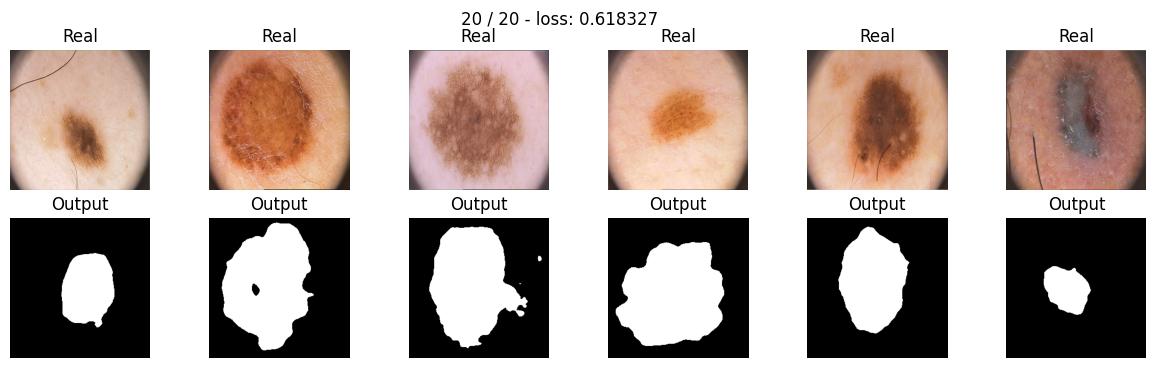

In [ ]:
train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)